In [64]:
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
# C -> hyperparameter
m = LogisticRegression(C=1e5, class_weight = {0: 60.0, 1: 40.0})
# solver='saga', intercept_scaling=5000, class_weight = {0: 2.0, 1: 1.0}, solver="liblinear"

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

df_train = pd.read_csv('train.csv', index_col=0)
df_test = pd.read_csv('predict.csv', index_col = 0)

In [2]:
len(df_train)

891

In [3]:
df_train.sample(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
820,0,3,"Skoog, Master. Karl Thorsten",male,10.0,3,2,347088,27.900,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.000,B42,S
777,0,3,"Tobin, Mr. Roger",male,NaN,0,0,383121,7.750,F38,Q
457,0,1,"Millet, Mr. Francis Davis",male,65.0,0,0,13509,26.550,E38,S
27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.225,NaN,C


info on function / package: "?"

In [4]:
#?LogisticRegression

In [5]:
#df_train.plot.scatter('Pclass', 'Survived')

In [6]:
#df_train.plot.scatter('Age', 'Survived')

## replace embarking harbour with numerical values -> use dummies!

In [7]:
# old idea: replace with values, better: use dummies
#df['Embarkednum'] = df['Embarked']
#df['Sexnum'] = df['Sex']
#df.replace({'Embarkednum': {'S': 0,'C': 1, 'Q': 2}}, inplace=True)
#df.replace({'Sexnum': {'male': 0, 'female': 1}}, inplace=True)
#df.head(5)
#--> create dummies instead -> one-hot
#df_test = pd.read_csv('predict.csv')

#df_test1 = df_test[['Pclass', 'Sex', 'Age', 'SibSp','Parch', 'Fare', 'Embarked']]
#df_test1.columns[df_test1.isna().any()].tolist()

#df_test1['Age'].fillna(df_test1['Age'].mean(), inplace=True)
#df_test1['Fare'].fillna(df_test1['Fare'].mean(), inplace=True)

#df_train2 = pd.get_dummies(df_test1,drop_first=False)


## highlight values

In [8]:
df_train.head(2).style.highlight_null(null_color='red')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,nan,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C


In [9]:
df_train.sample(5).style.bar(subset=['Age', 'Fare'], color='#d65f5f')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
430,1,3,"Pickard, Mr. Berk (Berk Trembisky)",male,32,0,0,SOTON/O.Q. 392078,8.05,E10,S
798,1,3,"Osman, Mrs. Mara",female,31,0,0,349244,8.6833,nan,S
873,0,1,"Carlsson, Mr. Frans Olof",male,33,0,0,695,5,B51 B53 B55,S
292,1,1,"Bishop, Mrs. Dickinson H (Helen Walton)",female,19,1,0,11967,91.0792,B49,C
295,0,3,"Mineff, Mr. Ivan",male,24,0,0,349233,7.8958,nan,S


## get first letter of cabin

In [65]:
df_train['CabinLet'] = df_train["Cabin"].str[:1]
df_train['CabinLet'].fillna(0, inplace=True)

## create dummy variable for Sex and merge with existing data frame, drop first value

In [66]:
df_train['Age'].fillna(df_train['Age'].mean(), inplace=True)
df_train['Fare'].fillna(df_train['Fare'].mean(), inplace=True)

df_train['AgeBin'] = pd.cut(df_train['Age'], [0, 25, 30, 70, 90], labels = [0, 1, 2, 3])
df_train['AgeBin'].fillna(method="ffill")

dummies_train_s = pd.get_dummies(df_train['Sex'], drop_first = True)
dummies_train_e = pd.get_dummies(df_train['Embarked'], drop_first = True)
dummies_train_c = pd.get_dummies(df_train['CabinLet'], drop_first = True)

df_train['AgeSq'] = df_train['Age'] ** 2
df_train['AgeMod'] = (df_train['Age'] - df_train['Age'].mean()) ** 2
                      
df_train['AgeSq'].fillna(df_train['AgeSq'].mean(), inplace=True)
df_train['AgeDemean'] = ((df_train['Age'] - df_train['Age'].mean())/df_train['Age'].mean()) ** 3

dummies_train1 = pd.merge(dummies_train_s, dummies_train_e, left_index=True, right_index=True)
dummies_train2 = pd.merge(dummies_train1, dummies_train_c, left_index=True, right_index=True)
# dummies_train2.head(2)

In [12]:
df_train['Age'].mean()

29.699117647058763

In [13]:
#df_train['SexAge'] = dummies_train2['male']+1 * df_train['Age']
#df_train['ParchMod'] = (df_train['Parch'])+(df_train['SibSp'])+1
# df_train.head()
#df_train['AgebinGen'] = df_train1['male'] * df_train1['AgeBin']

## Preprocessing function
props to Steffen!

In [51]:
def preprocessing (dataframe):
    dataframe['CabinLet'] = dataframe['Cabin'].str[:1]
    dataframe['CabinLet'].fillna(0, inplace=True)
    dataframe['Age'].fillna(dataframe['Age'].mean(), inplace=True)
    dataframe['Fare'].fillna(dataframe['Fare'].mean(), inplace=True)

    dataframe['AgeBin'] = pd.cut(dataframe['Age'], [0, 25, 30, 70, 90], labels = [0, 1, 2, 3])
    dataframe['AgeBin'].fillna(method="ffill")

    dummies_train_s = pd.get_dummies(dataframe['Sex'], drop_first = True)
    dummies_train_e = pd.get_dummies(dataframe['Embarked'], drop_first = True)
    dummies_train_c = pd.get_dummies(dataframe['CabinLet'], drop_first = True)
# --> put these in one dummy-df
    dummies_train1 = pd.merge(dummies_train_s, dummies_train_e, left_index=True, right_index=True)
    dummies_train2 = pd.merge(dummies_train1, dummies_train_c, left_index=True, right_index=True)
    
    dataframe['AgeSq'] = dataframe['Age'] ** 2
    dataframe['AgeMod'] = (dataframe['Age'] - dataframe['Age'].mean()) ** 2

    dataframe['AgeSq'].fillna(dataframe['AgeSq'].mean(), inplace=True)
    dataframe['AgeDemean'] = ((dataframe['Age'] - dataframe['Age'].mean())/dataframe['Age'].mean()) ** 3

    dataframe['SexAge'] = dummies_train2['male']+1 * dataframe['Age']
    dataframe['ParchMod'] = (dataframe['Parch'])+(dataframe['SibSp'])+1

    return dataframe

In [73]:
preprocessing(df_train)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinLet,AgeBin,AgeSq,AgeMod,AgeDemean,SexAge,ParchMod
PassengerId,,,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,0,0,484.000000,5.927641e+01,-1.742177e-02,23.000000,2
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,C,2,1444.000000,6.890465e+01,2.183444e-02,38.000000,2
3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,676.000000,1.368347e+01,-1.932252e-03,26.000000,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,C,2,1225.000000,2.809935e+01,5.686092e-03,35.000000,2
5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,0,2,1225.000000,2.809935e+01,5.686092e-03,36.000000,1
6,0,3,"Moran, Mr. James",male,29.699118,0,0,330877,8.4583,NaN,Q,0,1,882.037589,3.231174e-27,7.011484e-45,30.699118,1
7,0,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,17463,51.8625,E46,S,E,2,2916.000000,5.905329e+02,5.478170e-01,55.000000,1
8,0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21.0750,NaN,S,0,0,4.000000,7.672411e+02,-8.112733e-01,3.000000,5
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000000,0,2,347742,11.1333,NaN,S,0,1,729.000000,7.285236e+00,-7.506454e-04,27.000000,3


## merge dummy-dfs with train dataset and omit presumably irrelevant parameters

In [68]:
df_train1 = pd.merge(df_train[['Survived', 'Pclass', 'ParchMod', 'SexAge', 'AgeDemean']], dummies_train2, left_index=True, right_index=True)    

## Train model

In [69]:
X = df_train1.iloc[:,1:]
y = df_train1.iloc[:,0]

In [70]:
m.fit(X, y)
print(m.score(X, y))
#m.coef_, m.intercept_
#print(classification_report(y, ypred))

0.8204264870931538


## cross- validation

In [19]:
cross_val_score(X=X, y=y, estimator=m, cv=5)

array([0.79329609, 0.81005587, 0.81460674, 0.80898876, 0.81355932])

## feature engineering

In [71]:
scoar_rows = []
for al in range (0, 101):
    scoar_lines = []
    for parent in range (0, 101):
        df_train1['AgeDemean'] = ((df_train['SexAge'] - al)/al) ** 2
        df_train1['ParchMod'] = ((df_train['Parch'])+(df_train['SibSp'] * parent))
        df_train1 = pd.merge(df_train1[['Survived', 'Pclass', 'ParchMod', 'AgeDemean']], dummies_train2, left_index=True, right_index=True)
        X = df_train1.iloc[:,1:]
        y = df_train1.iloc[:,0]
        m.fit(X, y)
        scoar_lines.append(m.score(X, y))
    scoar_rows.append(scoar_lines)
#       print(al, m.score(X, y))            

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
#scoar_rows = []
#scoar_lines = []
#for al in range(1, 10):
#    scoar_lines = []
#    for parent in range(1, 10):
#        sq = al + parent
#        scoar_lines.append(sq)
#    scoar_rows.append(scoar_lines)
#       print(al, m.score(X, y))  

In [58]:
import numpy as np
scoar_rows = np.array(scoar_rows)

In [59]:
import seaborn as sns

In [60]:
sns.heatmap(scoar_rows, cmap = "Blues", annot=False)

IndexError: Inconsistent shape between the condition and the input (got (0, 1) and (0,))

## locate maximum value:

In [ ]:
np.where(scoar_rows == scoar_rows.max())
#np.where(scoar_rows.round(2) == 0.82)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d', )
ax.plot_trisurf(df_train['Age'], df_train['Parch'], df_train1['Survived'], cmap="Blues", linewidth=0.1)
ax.view_init(30, 45)
plt.show()

### look at entries that have not been classified correctly
('Lösen durch scharfes Hinsehen')

In [ ]:
df_train['predict'] = m.predict(X)
#df_train1 = pd.merge(df_train, dummies_train2, left_index=True, right_index=True)
(df_train[df_train['predict'] != df_train['Survived']]).sample(20)

In [ ]:
preprocessing(df_test)

In [ ]:
df_test.head(3)

In [ ]:
X_pred = df_test.iloc[:,0:]
#y_pred = df_test.iloc[:,0]

In [ ]:
X_predx

In [ ]:
scikitplot -> sklplt.metrics.plot_roc

In [ ]:
df_predict=pd.DataFrame(m.predict_proba(X_pred), columns = ['Survived_No', 'Survived_Yes'])
df_predict.round(decimals=2)
df_predict.head(3)

## Plot survival by Port of embarkation
-- Southhampton -- Cherbourg -- Queenstown --
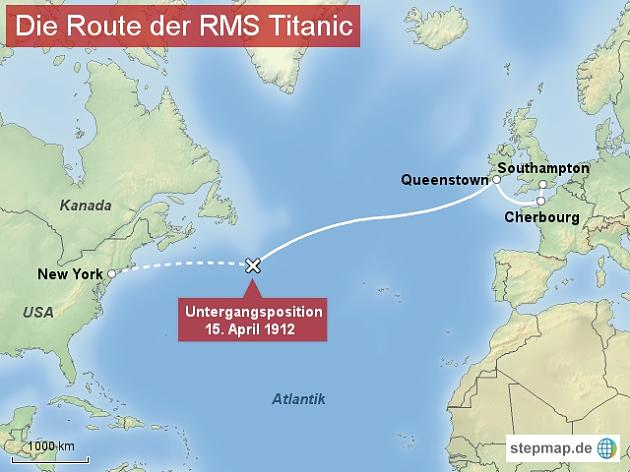

In [ ]:
df_train.groupby('Survived')['Fare'].hist()

In [ ]:
df_train.groupby('Survived')['Age'].hist()

In [ ]:
X, y = df(return_X_y=True)
m.fit(X, y)

print(m.score(X, y))

In [ ]:
df["Survived"].value_counts()

In [ ]:
df.groupby("Survived").mean()

## set up model

In [ ]:
df_train = pd.read
# fillna --> fill missing values with mean of column
# create dummies

pd.get_dummies(df_train, drop_first=True)
# --> 